In [1]:
# import os
# from google.colab import drive

# drive.mount('/content/gdrive')
# ROOT = "/content/gdrive/My Drive"

In [2]:
# import zipfile

# # Set paths
# zip_path = f'{ROOT}/channel_normalised.zip'
# extract_path = 'data/channel_normalised'

# # Unzip dataset
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Dataset extracted to:", extract_path)

In [3]:
import os
import keras

from helpers import data, runners, utils

In [4]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [5]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [6]:
utils.check_gpu_use()

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data

In [7]:
NUM_FOLDS = 10
INPUT_SHAPE = (192, 192, 1)
GPU_BATCH_SIZE = 16
DATA_BATCH_SIZE = 16
EPOCHS = 3

In [8]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv='deepship_5k_seg_3s.csv',
    new_path_to_root='data/channel_normalised/channel_normalised',
    ext='mat',
    unix=True,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)

# Initialise and configure model

In [9]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=INPUT_SHAPE,
    input_name='spec',
    num_classes=4,
    verbose=True
)

cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spec (InputLayer)           [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 128)     3328      
                                                                 
 batch_normalization (Batch  (None, 192, 192, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 192, 192, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       409

In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': EPOCHS,
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop(patience=3, restore_best_weights=True)]
}

eval_kwargs = {
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

# Run k-fold cross val

In [11]:
model, histories, evals, metrics = runners.k_fold_cross_validation(
    fold_dfs=fold_dfs,
    model=cnn_lstm_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    ext="mat",
    mat_var_name="channelNormalised",
    data_batch_size=DATA_BATCH_SIZE,
    use_cpu=False
)

FOLD 1/10
Epoch 1/3
2716/2716 [==============================] - 205s 72ms/step - loss: 0.7850 - acc: 0.6852 - val_loss: 0.8415 - val_acc: 0.6806
Epoch 2/3
2716/2716 [==============================] - 191s 70ms/step - loss: 0.4810 - acc: 0.8217 - val_loss: 0.9471 - val_acc: 0.6055
Epoch 3/3
1/1 [==============================] - 0s 37ms/step
FOLD 2/10
Epoch 1/3
2666/2666 [==============================] - 189s 71ms/step - loss: 0.2509 - acc: 0.9186 - val_loss: 0.3144 - val_acc: 0.8872
Epoch 2/3
2666/2666 [==============================] - 188s 70ms/step - loss: 0.1540 - acc: 0.9581 - val_loss: 0.3531 - val_acc: 0.8637
Epoch 3/3
1/1 [==============================] - 0s 40ms/step
FOLD 3/10
Epoch 1/3
2527/2527 [==============================] - 185s 73ms/step - loss: 0.1165 - acc: 0.9656 - val_loss: 0.2216 - val_acc: 0.9166
Epoch 2/3
2527/2527 [==============================] - 183s 73ms/step - loss: 0.0476 - acc: 0.9912 - val_loss: 0.1674 - val_acc: 0.9401
Epoch 3/3
1/1 [===============

In [14]:
model.save(f'gdrive/MyDrive/cnn_lstm_channel_norm_18112024/cnn_lstm_channel_norm_3_epochs.keras')

# Calculate metrics

In [15]:
evals

[[0.8908701539039612, 0.6556978821754456],
 [0.9776474237442017, 0.6838557124137878],
 [0.5729000568389893, 0.7989864945411682],
 [0.5691478848457336, 0.8156120181083679],
 [0.12294238805770874, 0.9576446413993835],
 [0.08733467757701874, 0.968406617641449],
 [0.06546851992607117, 0.9776503443717957],
 [0.06897877901792526, 0.9730356931686401],
 [0.023439714685082436, 0.9922975301742554],
 [0.07966706901788712, 0.9750000238418579]]

In [16]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 0.34583966676145794
Average accuracy: 0.8798186957836152


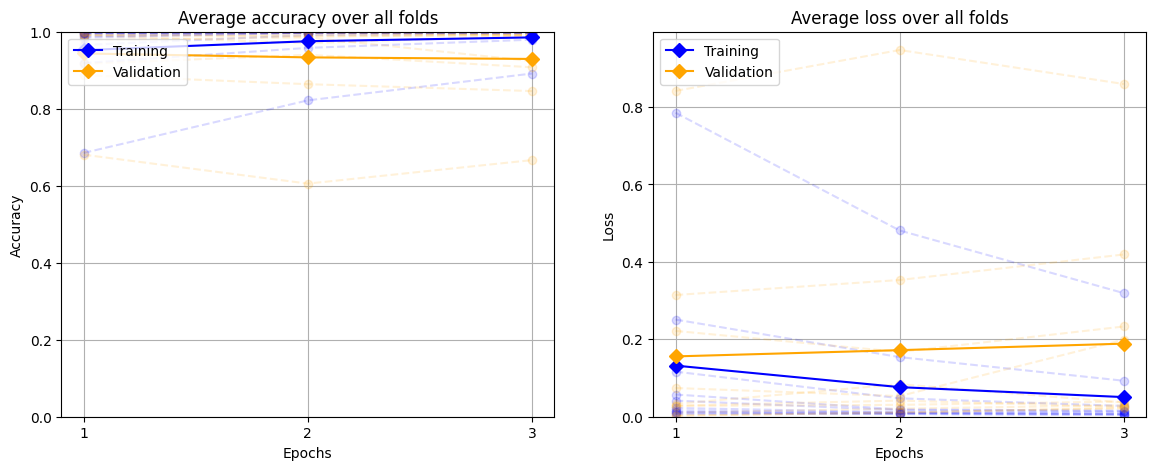

In [18]:
fig = utils.get_acc_loss_curves_by_epoch(histories, overlay=True)
model.save(f'gdrive/MyDrive/cnn_lstm_channel_norm_18112024/img/3_epochs_by_epoch.keras')
fig.show()

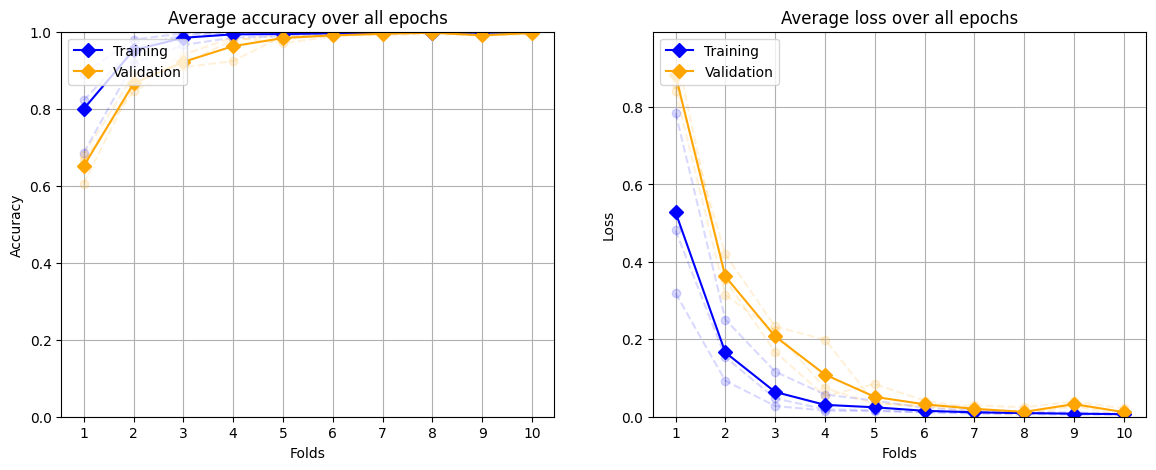

In [19]:
fig = utils.get_acc_loss_curves_by_fold(histories, overlay=True)
model.save(f'gdrive/MyDrive/cnn_lstm_channel_norm_18112024/img/3_epochs_by_fold.keras')
fig.show()

In [20]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])
print("Average Accuracy:", metrics["accuracy"])

Average Precision: 0.8910671639719485
Average Recall: 0.8798186872129804
Average F1 Score: 0.8809299052789404
Average Accuracy: 0.8798186872129804
